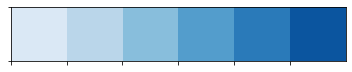

In [6]:
# coding: utf-8
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score,auc
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import eli5
from eli5.sklearn import PermutationImportance
import shap
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectFromModel
from Dependency_dsct import *
from Entropy_dsct import *
import gc
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
sns.palplot(sns.color_palette("Blues"))
sns.set_style('whitegrid')
sns.set(font_scale=2)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## 读取数据

In [7]:
train_label = pd.read_csv('train_label.csv')
train_base = pd.read_csv('train_base.csv')
test_base = pd.read_csv('test_a_base.csv')

train_op = pd.read_csv('train_op.csv')
train_trans = pd.read_csv('train_trans.csv')
test_op = pd.read_csv('test_a_op.csv')
test_trans = pd.read_csv('test_a_trans.csv')

## 定义所用到的函数及特征工程

In [23]:
def load_dataset(DATA_PATH):
    train_label = pd.read_csv(DATA_PATH+'train_label.csv')
    train_base = pd.read_csv(DATA_PATH+'train_base.csv')
    test_base = pd.read_csv(DATA_PATH+'test_a_base.csv')

    train_op = pd.read_csv(DATA_PATH+'train_op.csv')
    train_trans = pd.read_csv(DATA_PATH+'train_trans.csv')
    test_op = pd.read_csv(DATA_PATH+'test_a_op.csv')
    test_trans = pd.read_csv(DATA_PATH+'test_a_trans.csv')

    return train_label, train_base, test_base, train_op, train_trans, test_op, test_trans

def kfold_stats_feature(train, test, feats, k):
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=2020)  # 这里最好和后面模型的K折交叉验证保持一致

    train['fold'] = None
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['label'])):
        train.loc[val_idx, 'fold'] = fold_

    kfold_features = []
    for feat in feats:
        nums_columns = ['label']
        for f in nums_columns:
            colname = feat + '_' + f + '_kfold_mean'
            kfold_features.append(colname)
            train[colname] = None
            for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['label'])):
                tmp_trn = train.iloc[trn_idx]
                order_label = tmp_trn.groupby([feat])[f].mean()
                tmp = train.loc[train.fold == fold_, [feat]]
                train.loc[train.fold == fold_, colname] = tmp[feat].map(order_label)
                # fillna
                global_mean = train[f].mean()
                train.loc[train.fold == fold_, colname] = train.loc[train.fold == fold_, colname].fillna(global_mean)
            train[colname] = train[colname].astype(float)

        for f in nums_columns:
            colname = feat + '_' + f + '_kfold_mean'
            test[colname] = None
            order_label = train.groupby([feat])[f].mean()
            test[colname] = test[feat].map(order_label)
            # fillna
            global_mean = train[f].mean()
            test[colname] = test[colname].fillna(global_mean)
            test[colname] = test[colname].astype(float)
    del train['fold']
    return train, test

def gen_user_group_amount_features(df, value):
    group_df = df.pivot_table(index='user',
                              columns=value,
                              values='amount',
                              dropna=False,
                              aggfunc=['count', 'sum','mean']).fillna(0)
    group_df.columns = ['user_{}_{}_amount_{}'.format(value, f[1], f[0]) for f in group_df.columns]
    group_df.reset_index(inplace=True)

    return group_df

def transform_time(x):
    day = int(x.split(' ')[0])
    hour = int(x.split(' ')[2].split('.')[0].split(':')[0])
    minute = int(x.split(' ')[2].split('.')[0].split(':')[1])
    second = int(x.split(' ')[2].split('.')[0].split(':')[2])
    return 86400*day+3600*hour+60*minute+second

def data_preprocess(train_label, train_base, test_base, train_op, train_trans, test_op, test_trans):
    #train_label, train_base, test_base, train_op, train_trans, test_op, test_trans = load_dataset(DATA_PATH=DATA_PATH)
    # 拼接数据
    
    train_df = train_base.copy()
    test_df = test_base.copy()
    train_df = train_label.merge(train_df, on=['user'], how='left')
    del train_base, test_base

    op_df = pd.concat([train_op, test_op], axis=0, ignore_index=True)
    trans_df = pd.concat([train_trans, test_trans], axis=0, ignore_index=True)
    data = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    del train_op, test_op, train_df, test_df
    # 时间维度的处理
#     op_df['days_diff'] = op_df['tm_diff'].apply(lambda x: int(x.split(' ')[0]))
#     trans_df['days_diff'] = trans_df['tm_diff'].apply(lambda x: int(x.split(' ')[0]))
#     op_df['timestamp'] = op_df['tm_diff'].apply(lambda x: transform_time(x))
#     trans_df['timestamp'] = trans_df['tm_diff'].apply(lambda x: transform_time(x))
#     op_df['hour'] = op_df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[0]))
#     trans_df['hour'] = trans_df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[0]))
#     trans_df['week'] = trans_df['days_diff'].apply(lambda x: x % 7)
    # 排序
#     trans_df = trans_df.sort_values(by=['user', 'timestamp'])
#     op_df = op_df.sort_values(by=['user', 'timestamp'])
#     trans_df.reset_index(inplace=True, drop=True)
#     op_df.reset_index(inplace=True, drop=True)

    gc.collect()
    return data, op_df, trans_df

def gen_op_features(df):
    df['days'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[0]))
    df['hour'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[0]))
    df['minute'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[1]))
    df['second'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[2]))
    df['timestamp'] = df['tm_diff'].apply(lambda x: transform_time(x))
    df = df.sort_values(by=['user', 'timestamp'])
    df['time_interval']=df.groupby(['user','days','hour'])['timestamp'].transform('diff').fillna(0)
    op_group = df.groupby(['user']).agg({'op_type':['nunique'],
                               'op_mode':['nunique'],
                               'time_interval':['max','min','mean','std','skew','median','nunique'],
                               'op_device':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'ip':['nunique',lambda x:x.isnull().sum()/len(x)],
                               'net_type':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'channel':['nunique',lambda x:x.isnull().sum()/len(x)],
                               'ip_3':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'days':['max','min','mean','std','skew','median','nunique','count'],
                                'hour':['max','min','mean','std','skew','median','nunique']})
    op_group.columns = ['op_{}_{}'.format(f[1], f[0]) for f in op_group.columns]
    op_group.reset_index(inplace=True)
    return op_group

def gen_trans_features(df):
    df['days'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[0]))
    df['hour'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[0]))
    df['minute'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[1]))
    df['second'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[2]))
    df['timestamp'] = df['tm_diff'].apply(lambda x: transform_time(x))
    df = df.sort_values(by=['user', 'timestamp'])
    df['time_interval']=df.groupby(['user','days','hour'])['timestamp'].transform('diff').fillna(0)
    trans_group = df.groupby(['user']).agg({'platform':['nunique'],
                               'type1':['nunique',('top_type1_cnt',lambda x:np.sum((x=='45a1168437c708ff')))],
                               'time_interval':['max','min','mean','std','skew','median','nunique'],
                               'tunnel_in':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'ip':['nunique',lambda x:x.isnull().sum()/len(x)],
                               'tunnel_out':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'type2':['nunique',lambda x:x.isnull().sum()/len(x)],
                               'ip_3':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'amount':['max','min','mean','std','skew','median','sum'],
                                'days':['max','min','mean','std','skew','median','nunique','count'],
                                'hour':['max','min','mean','std','skew','median','nunique']})
    trans_group.columns = ['trans_{}_{}'.format(f[1], f[0]) for f in trans_group.columns]
    trans_group.reset_index(inplace=True)
    trans_group['amount_per_day'] = trans_group['trans_sum_amount']/trans_group['trans_nunique_days']
    return trans_group

def gen_features(df, op, trans):
    #df.drop(['city'], axis=1, inplace=True)
    df['product7_fail_ratio'] = df['product7_fail_cnt'] / df['product7_cnt']
    df['city_count'] = df.groupby(['city'])['user'].transform('count')
    df['province_count'] = df.groupby(['province'])['user'].transform('count')
    df['sex_null'] = np.where(df['sex'].isnull(),'1','0') 
    df['balance_null'] = np.where(df['balance_avg'].isnull(),'1','0')
    df['service3_level_null'] = np.where(df['service3_level'].isnull(),'1','0')
    df['province_count'] = df.groupby(['province'])['user'].transform('count')

    df = df.merge(op.drop_duplicates(subset=['user'])[['user','op_type']],on='user',how='left')

    df['op_type'] = np.where(df['op_type'].isnull(),1,0)
    df = df.merge(trans.drop_duplicates(subset=['user'])[['user','platform']],on='user',how='left')
    df['platform'] = np.where(df['platform'].isnull(),1,0)
    df.rename(columns={'op_type':'op_null','platform':'trans_null'},inplace=True)
#     # trans
    df = df.merge(gen_user_group_amount_features(df=trans, value='platform'), on=['user'], how='left')
    df = df.merge(gen_user_group_amount_features(df=trans, value='type1'), on=['user'], how='left')
    df = df.merge(gen_user_group_amount_features(df=trans, value='type2'), on=['user'], how='left')
    df = df.merge(gen_user_group_amount_features(df=trans, value='tunnel_in'), on=['user'], how='left')
    df = df.merge(gen_user_group_amount_features(df=trans, value='tunnel_out'), on=['user'], how='left')
    
    df = df.merge(gen_trans_features(df=trans), on=['user'], how='left')
#     # op
    df = df.merge(gen_op_features(df=op), on=['user'], how='left')
    # LabelEncoder
    cat_cols = []
    for col in tqdm([f for f in df.select_dtypes('object').columns if f not in ['user']]):
        le = LabelEncoder()
        df[col].fillna('-1', inplace=True)
        df[col] = le.fit_transform(df[col])
        cat_cols.append(col)

    return df

def correlation(dataset,threshold):
    corr_features = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if abs(corr_matrix.iloc[i][j]) >= threshold:
                corr_features.add(dataset.columns[i])
    return corr_features

feature_importance_df = pd.DataFrame()
def lgb_model(train, target, test, k):
    feats = [f for f in train.columns if f not in ['user', 'label']]
    print('Current num of features:', len(feats))
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=2020)
    oof_probs = np.zeros(train.shape[0])
    output_preds = 0
    offline_score = []
    global feature_importance_df
    parameters = {
        'learning_rate': 0.01,
        'boosting_type': 'gbdt',
        'is_training_metric': True,
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 60,
        #'is_unbalance':True,
        'scale_pos_weight':0.6,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'min_data_in_leaf': 100,
        'max_depth': 5,
        'verbose': -1,
        'nthread': 8,
        'lambda_l1': 0.7,
        'lambda_l2': 0.7,
    }
    
    
    for i, (train_index, test_index) in enumerate(folds.split(train, target)):
        train_y, test_y = target[train_index], target[test_index]
        train_X, test_X = train[feats].iloc[train_index, :], train[feats].iloc[test_index, :]

        dtrain = lgb.Dataset(train_X,
                             label=train_y)
        dval = lgb.Dataset(test_X,
                           label=test_y)
#         lgb_model = lgb.LGBMClassifier(n_estimators=5000,
#                          #**params, 
#                          num_leaves=60,
#                          boost_from_average=False,
#                          objective='binary',
#                          max_depth=5,
#                          learning_rate=0.01,
#                          boosting='gbdt',
#                          min_data_in_leaf=100,
#                          bagging_freq=5,
#                          bagging_fraction=0.8,
#                          feature_fraction=0.8,
#                          #bagging_seed=11,
#                          reg_alpha=0.7,
#                          reg_lambda=0.7,
#                          metric='auc',
#                          verbosity=1,
#                          importance_type='gain',
#                          #subsample=0.81,
#                           num_threads=8)
        
#         lgb_model.fit(train_X, train_y, eval_set=[(train_X, train_y),(test_X, test_y)], verbose=100,
#         early_stopping_rounds=100)
        
        lgb_model = lgb.train(
                parameters,
                dtrain,
                num_boost_round=5000,
                valid_sets=[dtrain,dval],
                early_stopping_rounds=100,
                verbose_eval=100,
        )
        oof_probs[test_index] = lgb_model.predict(test_X[feats], num_iteration=lgb_model.best_iteration)
        offline_score.append(lgb_model.best_score['valid_1']['auc'])
        output_preds += lgb_model.predict(test[feats], num_iteration=lgb_model.best_iteration)/folds.n_splits
        print(offline_score)
        # feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = lgb_model.feature_importance()
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('OOF-MEAN-AUC:%.6f, OOF-STD-AUC:%.6f' % (np.mean(offline_score), np.std(offline_score)))
    print('AUC 分数 ',round(roc_auc_score(target, oof_probs), 6))
    #print('feature importance:')
    #print(fold_importance_df)
    #print(feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).head(30))
    
    plt.figure(figsize=(25,12))
    feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).head(30).sort_values().plot(kind='barh')
    plt.title("Feature importances")
    plt.show()
    return output_preds, oof_probs, np.mean(offline_score),lgb_model


## 模型训练

读取数据...
开始特征工程...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 51.61it/s]


相关性高于0.99的特征一共23个
删除相关性高于0.99的特征...
开始模型训练...
Current num of features: 258
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.723404	valid_1's auc: 0.710011
[200]	training's auc: 0.734978	valid_1's auc: 0.718311
[300]	training's auc: 0.744104	valid_1's auc: 0.724346
[400]	training's auc: 0.751384	valid_1's auc: 0.728546
[500]	training's auc: 0.760308	valid_1's auc: 0.731582
[600]	training's auc: 0.770022	valid_1's auc: 0.733714
[700]	training's auc: 0.779245	valid_1's auc: 0.735783
[800]	training's auc: 0.787263	valid_1's auc: 0.737049
[900]	training's auc: 0.794273	valid_1's auc: 0.738049
[1000]	training's auc: 0.801134	valid_1's auc: 0.738933
[1100]	training's auc: 0.807633	valid_1's auc: 0.739225
[1200]	training's auc: 0.814137	valid_1's auc: 0.739317
[1300]	training's auc: 0.819632	valid_1's auc: 0.739687
[1400]	training's auc: 0.824961	valid_1's auc: 0.739732
Early stopping, best iteration is:
[1353]	training's auc: 0.822432	valid_1's auc: 0.7397

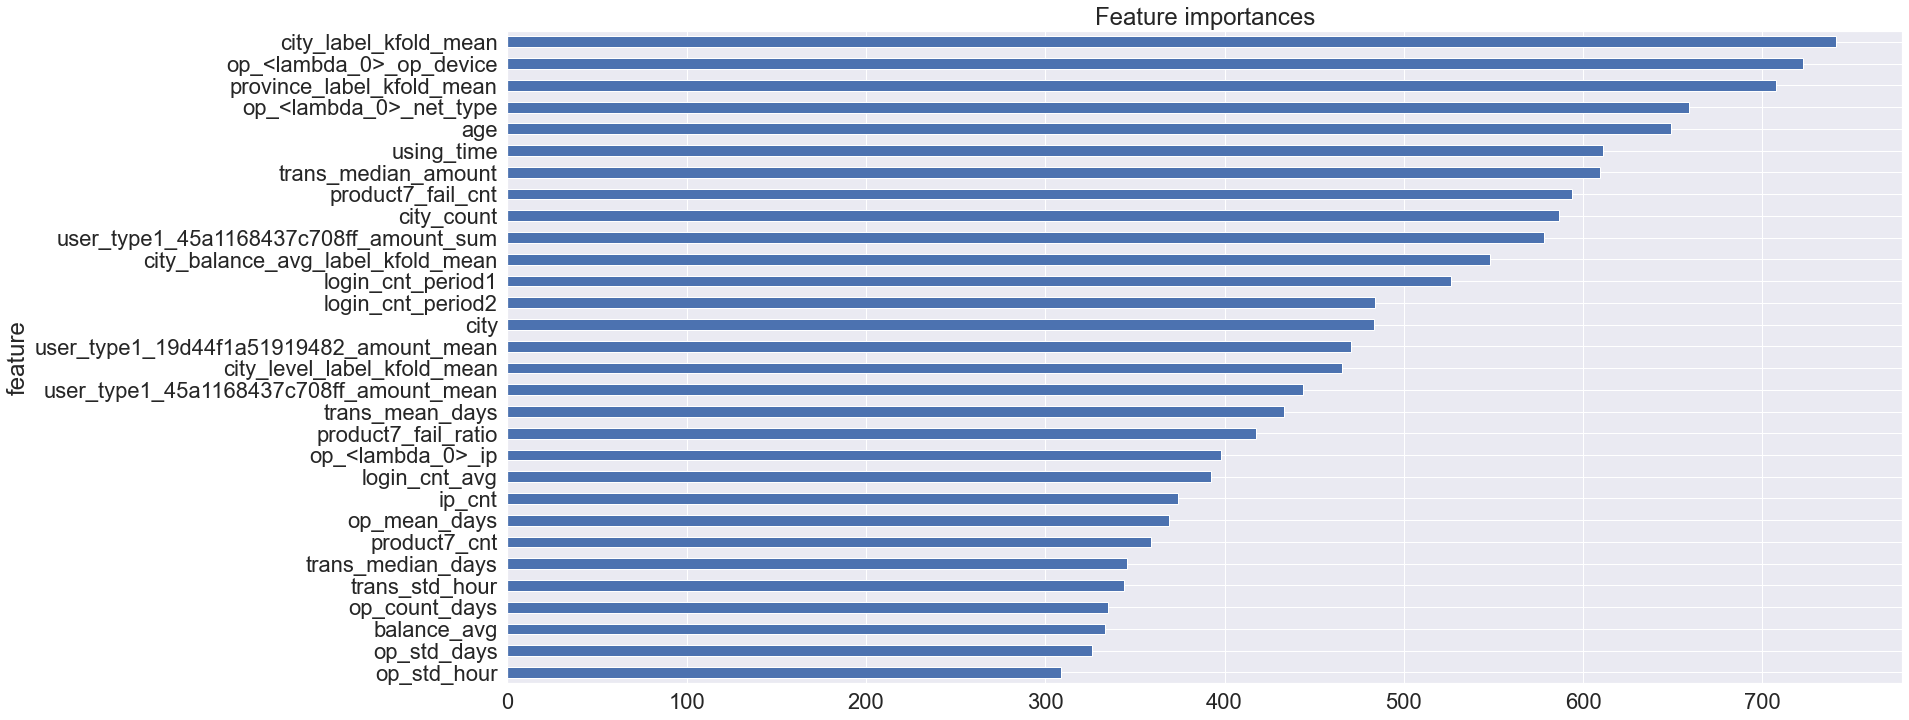

In [24]:
if __name__ == '__main__':
    DATA_PATH = ''
    print('读取数据...')
    data, op_df, trans_df = data_preprocess(train_label, train_base, test_base, train_op, train_trans, test_op, test_trans)

    print('开始特征工程...')
    data = gen_features(data, op_df, trans_df)
    data['city_level'] = data['city'].map(str) + '_' + data['level'].map(str)
    data['city_balance_avg'] = data['city'].map(str) + '_' + data['balance_avg'].map(str)
    
    train = data[~data['label'].isnull()].copy()
    target = train['label']
    test = data[data['label'].isnull()].copy()

    target_encode_cols = ['province', 'city', 'city_level', 'city_balance_avg']
    train, test = kfold_stats_feature(train, test, target_encode_cols, 5)
    train.drop(['city_level', 'city_balance_avg'], axis=1, inplace=True)
    test.drop(['city_level', 'city_balance_avg'], axis=1, inplace=True)
    
    corr_features = correlation(train,0.99)
    corr_cols = list(corr_features)
    print('相关性高于0.99的特征一共{}个'.format(len(corr_cols)))
    print('删除相关性高于0.99的特征...')
    train.drop(corr_cols, axis=1, inplace=True)
    test.drop(corr_cols, axis=1, inplace=True)
    
    train.fillna(-999,inplace=True)
    test.fillna(-999,inplace=True)
    #train.drop(dtop_cols,axis=1,inplace=True)
    #smo = SMOTE(random_state=42)
    #X_smo, y_smo = smo.fit_sample(train.drop(['user'],axis=1),target)
    print('开始模型训练...')
    lgb_preds, lgb_oof, lgb_score, my_model= lgb_model(train=train, target=target, test=test, k=5)

    sub_df = test[['user']].copy()
    sub_df['prob'] = lgb_preds
    sub_df.to_csv('sub.csv', index=False)

In [ ]:
# OOF-MEAN-AUC:0.692181
# OOF-MEAN-AUC:0.692979
# 不做任何处理 OOF-MEAN-AUC:0.688149
# 加入特征op，trans是否为空：OOF-MEAN-AUC:0.688590 AUC 分数  0.688278
# 加入特征service3_level是否为空 OOF-MEAN-AUC:0.689183 AUC 分数  0.688988
# 加入city等target_encode OOF-MEAN-AUC:0.694512
# 加入product7_fail_ratio申请失败比例，城市，省平均用户数等特征 OOF-MEAN-AUC:0.698484
# 加入op的简单统计特征 OOF-MEAN-AUC:0.706731
# 降低max_depth,增加min_data_in_leaf。降低过拟合 OOF-MEAN-AUC:0.710617
# 增加了时间间隔，auc反而降低了OOF-MEAN-AUC:0.710148
# 加入trans简单统计特征OOF-MEAN-AUC:0.721021
# 加入金额的统计特征：OOF-MEAN-AUC:0.726744  OOF-MEAN-AUC:0.729719
# 去除完全相关（大于等于0.999，剩下183个features）OOF-MEAN-AUC:OOF-MEAN-AUC:0.732100

## 使用eli5工具查看特征重要性

In [93]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(lgb_trained_model
                             , random_state=1).fit(X, target)
eli5.show_weights(lgb_trained_model, top=200)
eli5.show_weights(perm, top=200,
                  feature_names =X.columns.tolist())

Weight,Feature
0.0091 ± 0.0008,product7_fail_ratio
0.0046 ± 0.0009,user_type1_45a1168437c708ff_amount_sum
0.0036 ± 0.0009,trans_median_amount
0.0033 ± 0.0007,login_cnt_period1
0.0032 ± 0.0006,product7_fail_cnt
0.0031 ± 0.0007,age
0.0031 ± 0.0008,city_label_kfold_mean
0.0030 ± 0.0007,trans_mean_days
0.0028 ± 0.0006,trans_top_type1_cnt_type1
0.0024 ± 0.0002,user_type1_674e8d5860bc033d_amount_sum


## 使用Shap工具解释特征作用

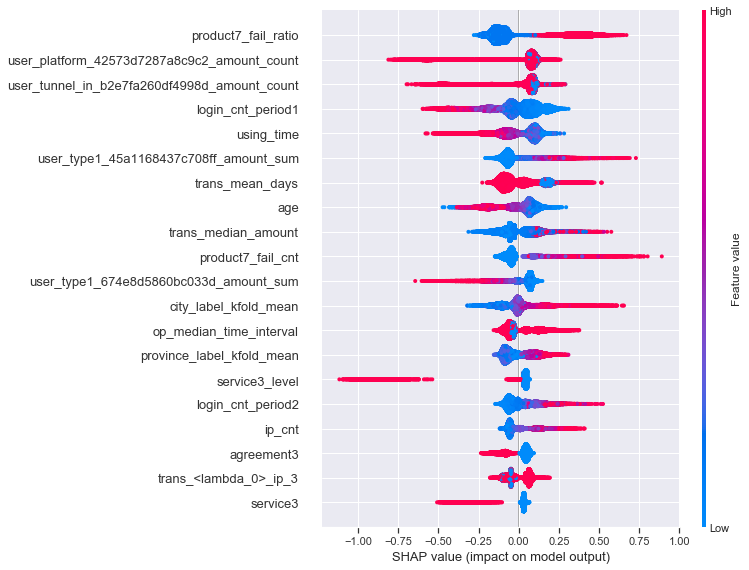

In [73]:
import shap 
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(train_drop.drop(['user','label'],axis=1))
shap.summary_plot(shap_values[1], train_drop.drop(['user','label'],axis=1))

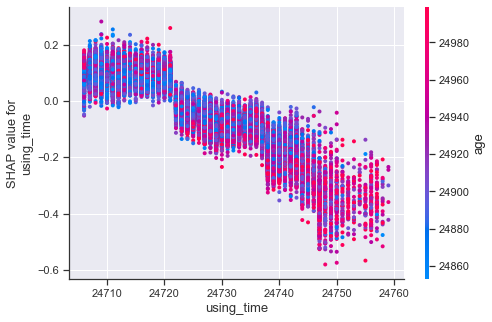

In [81]:
import shap 
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X)
shap.dependence_plot('using_time', shap_values[1], 
                     X,interaction_index='age')